# Data Preprocessing

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import csv
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))

from datetime import datetime
from tqdm import tqdm
from scipy import stats

import requests
import os
import shutil

import warnings

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]

## Load the dataset

In [2]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

df_origin = pd.read_csv('games-regression-dataset.csv', 
                        parse_dates=['Original Release Date' , 'Current Version Release Date'], 
                        date_parser=dateparse)

## Download the icons

In [3]:
# Convert to string
df_origin['Icon URL'] = df_origin['Icon URL'].astype(str)

# Download the images
def download_image(url, filename):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)


# Create a folder to store the images
if not os.path.exists('icons'):
    os.makedirs('icons')

# Download the images if they don't exist
for i, row in tqdm(df_origin.iterrows(), total=df_origin.shape[0]):
    if not os.path.exists('icons/' + str(i) + '.png'):
        download_image(row['Icon URL'], 'icons/' + str(i) + '.png')
        
# Replace the URL with the icon filename which is the index of the row
df_origin['Icon URL'] = df_origin.apply(lambda row : f'icons/{row.name}.png', axis=1)

100%|██████████| 5214/5214 [00:00<00:00, 8038.12it/s]


## Download the reviews

In [ ]:
def web_scrapping():
    data = pd.DataFrame(columns = ["ID","Reviews"])
    # Read CSV file
    # with open('games-regression-dataset.csv', newline='') as csvfile:
    with open('games-regression-dataset.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        for row in reader:
            url = row[0]  # URL is in first column
            filename = 'Reviews/'+os.path.basename(url)  # Extract filename from URL
            url +=  "?see-all=reviews"
            response = requests.get(url)
            if response.status_code == 200:  # Check if request was successful
                soup = BeautifulSoup(response.text, 'html.parser')
                blocks = soup.findAll("blockquote")
                review_list = []
                for blockquote in blocks:
                    review = blockquote.find('p').text
                    review_list.append(review)
                if len(review_list)!=0:
                    filename = re.sub(r'[^\d]+', '', filename)
                    new_row = {'ID': filename,"Reviews": review_list}
                    data = data._append(new_row, ignore_index=True)
                    
    data.to_csv('Reviews.csv', index=False)

In [5]:
def reviews_splitting(data):

    for i in range (len(data)):
        data.at[i, 'Reviews'] = data.at[i, "Reviews"].split("',")
        data.at[i,"ID"] =data.at[i,"ID"]
        
    data = data.explode('Reviews')
    return data

In [6]:
def reviews_cleaning(data):
  # Convert text to lowercase
  data['Reviews'] = data['Reviews'].apply(lambda x: str(x).lower())

  # Replace newline characters with an empty string
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\\n', ' ', x))

  # Remove black squares
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\\u25a0', '', x))

  # Remove special characters and punctuations
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'[^\w\s]+', '', x))

  # Remove numbers
  data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.split() if not any(char.isdigit() for char in word)]))

  # Remove extra whitespaces
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\s+', ' ', x))

  # Remove stop words
  data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.lower().split() if word not in stop_words]))

  # Remove empty strings
  data = data[data['Reviews'].apply(lambda x: len(x)>0)]
  
  # Group by ID
  data = data.groupby('ID')['Reviews'].apply(list).reset_index()
  
  return data

In [7]:
# web_scrapping()

df_reviews = pd.read_csv('Reviews.csv')

df_reviews = reviews_splitting(df_reviews)

df_reviews = reviews_cleaning(df_reviews)

## Merge The Sentiment with the original dataset
df_origin = df_origin.merge(df_reviews, on='ID', how='left')

## drop the rows with no reviews
df_origin = df_origin.dropna(subset=['Reviews'])

In [ ]:
df_origin.shape

## Sentiment Analysis for reviews

### Sentiment Analysis

In [8]:
sia_reviews = SentimentIntensityAnalyzer()
pickle.dump(sia_reviews, open('encoders/sia_reviews.pkl', 'wb'))

def sentiment_analysis(data):
  
  # Apply sentiment analysis for each review in the list
  data['Reviews'] = data['Reviews'].apply(lambda x: [sia_reviews.polarity_scores(review)['compound'] for review in x])
  
  return data


### Get compound average & Group by id


In [9]:

def reviews_preprocess(data):
  
  # Apply sentiment_analysis
  data = sentiment_analysis(data)
  
  # Get the lowest, highest and average Reviews
  data['lowest_review'] = data['Reviews'].apply(lambda x: min(x) if len(x) > 0 else 0)
  data['highest_review'] = data['Reviews'].apply(lambda x: max(x) if len(x) > 0 else 0)
  data['average_review'] = data['Reviews'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
  
  ## Drop nulls of sentiment
  # data = data.dropna(subset=['lowest_review','highest_review','average_review'])
  return data

## Data Exploration

### General information

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

### Genres

In [ ]:
def genres_analysis(_df):
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

    genre_counts = _df.explode('Genres').groupby('Genres').size().sort_values(ascending=False)
    print(genre_counts)


### Developer

In [ ]:
def dev_analysis(_df):

    print(_df['Developer'].value_counts())
    
    # print the number developers with more than 1 game
    print(len(_df['Developer'].value_counts()[_df['Developer'].value_counts() > 1]))

    print(_df['Developer'].unique().size)

### Dates

In [ ]:
def date_analysis(_df):
    # Plot the distribution of the date columns

    fig, ax = plt.subplots(5, 2, figsize=(20, 20))

    # df = date_preprocessing(df)

    # game_age distribution
    sns.histplot(_df['game_age'], ax=ax[0, 0])
    sns.boxplot(_df['game_age'], ax=ax[0, 1], orient='h')

    # last_update distribution
    sns.histplot(_df['last_update'], ax=ax[1, 0])
    sns.boxplot(_df['last_update'], ax=ax[1, 1], orient='h')

    # Original Release Date distribution
    sns.histplot(_df['Original Release Date'], ax=ax[2, 0])
    sns.boxplot(_df['Original Release Date'], ax=ax[2, 1], orient='h')

    # Current Version Release Date distribution
    sns.histplot(_df['Current Version Release Date'], ax=ax[3, 0])
    sns.boxplot(_df['Current Version Release Date'], ax=ax[3, 1], orient='h')

    # maintaning_period distribution
    sns.histplot(_df['maintaning_period'], ax=ax[4, 0])
    sns.boxplot(_df['maintaning_period'], ax=ax[4, 1], orient='h')

    plt.show()

# Date outliers are legitimate data points that are worth keeping, they are not errors nor anomalies

### Languages

In [ ]:
def lang_analysis(_df):
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

    langs_counts = _df.explode('Languages').groupby('Languages').size().sort_values(ascending=False)
    print(langs_counts[1:30])


In [ ]:
df.hist(figsize=(15, 15))

## Dates preprocessing

In [10]:
def date_preprocess(_df):
    # Convert the datetime to ordinal
    _df['Original Release Date'] = _df['Original Release Date'].apply(lambda x: x.toordinal())
    _df['Current Version Release Date'] = _df['Current Version Release Date'].apply(lambda x: x.toordinal())
    
    # Create a new column with the age of the game
    _df['game_age'] = datetime.now().toordinal() - _df['Original Release Date']

    # Create a new column with the time since the last update
    _df['last_update'] = datetime.now().toordinal() - _df['Current Version Release Date']
    
    # Create a new column with the maintaning period
    _df['maintaning_period'] = _df['last_update'] - _df['game_age']

    return _df

## Developer preprocessing

### Target encoding approach

In [11]:
def dev_preprocess_target_enc(_df):
    # Convert to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')

    # Replace the developer names with less than 2 games with 'Other'
    dev_counts = _df['Developer'].value_counts()
    other = dev_counts[dev_counts < 2].index
    
    # Drop rows with developers in other
    # _df = _df[~_df['Developer'].isin(other)]
    
    _df['Developer'] = _df['Developer'].replace(other, 'Other')

    # Get the average user rating for all the developers that have more than 1 game
    mean = _df.groupby('Developer').filter(lambda x: len(x) > 1)['Average User Rating'].mean()
    
    dev_df = _df[['Developer', 'Average User Rating']].groupby('Developer').mean()
    
    # Replace the value of 'Other' with the mean
    dev_df.loc['Other'] = mean

    # Save dev_df to be used on the test set
    dev_df.to_csv('encoders/dev_avg.csv')

    # Replace the developer names with the average user rating from dev_df
    _df['dev_avg'] = _df['Developer'].replace(dev_df.index, dev_df['Average User Rating'])
    
    return _df

### Frequency encoding approach

In [12]:
# Frequency encoding

def dev_preprocess_freq_enc(_df):
    # Convert to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')
    
    # Get the frequency of each developer
    dev_freqs = pd.value_counts(_df['Developer']).reset_index()
    dev_freqs.columns = ['Developer', 'Frequency']
    
    # Save dev_freqs to be used on the test set
    dev_freqs.to_csv('encoders/dev_freq.csv', index=False)
    
    # Create a dictionary mapping developers to frequencies
    dev_freq_dict = dict(zip(dev_freqs['Developer'], dev_freqs['Frequency']))

    # Create a new column with the frequency of each developer
    _df['dev_freq'] = _df['Developer'].map(dev_freq_dict)
        
    return _df


## Genres preprocessing

### 1. NLP approach (Bag of Words)

In [ ]:
def genres_preprocess_bow(_df):
    # Convert the genres column to a list of strings
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

    # drop Games, Strategy, Entertainment from the Genres column
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

    # Join the list of genres into a single string
    genres = _df['Genres'].apply(lambda x: ' '.join(x))

    # Create a count Vectorizer and fit it to the genres
    count_vec = CountVectorizer()
    bow_genres = count_vec.fit_transform(genres)
    
    # Save the count vectorizer to be used on the test set
    pickle.dump(count_vec, open('encoders/count_vec.pkl', 'wb'))

    # Apply principal component analysis to reduce the dimensionality
    pca = PCA(n_components=10)
    pca_genres = pca.fit_transform(bow_genres.toarray())

    # Add the PCA-transformed genres to the original dataframe
    for i in range(10):
        _df[f'genreN_{i}'] = pca_genres[:, i]

    return _df

### 2. Dummy variables approach

In [13]:
def genres_preprocess_dummies(_df):
    # Convert the genres column to a list of strings
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # drop Games, Strategy, Entertainment from the Genres column
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])
    
    # Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
    threshold = _df.shape[0] * 0.02
    
    other = _df['Genres'].explode().value_counts()[_df['Genres'].explode().value_counts() < threshold].index
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent' for genre in x])
    
    # Get dummy variables for the genres
    genres = pd.get_dummies(_df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)
    
    # Save the genres dummies to be used on the test set
    genres.to_csv('encoders/genres.csv', index=False)
    
    # Add the dummy variables to the original dataframe
    _df = pd.concat([_df, genres], axis=1)
    
    # Fill the NaN values with 0
    genre_cols = [col for col in _df.columns if col.startswith('genre')] # get all columns with prefix 'genre'
    _df[genre_cols] = _df[genre_cols].fillna(0) # fill the NaN values with 0
    
    return _df

### 3. Multi-label binarizer

In [ ]:
def genres_preprocessing_mlb(_df):
    # Convert the genres column to a list of strings
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

    # drop Games, Strategy, Entertainment from the Genres column
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

    # Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
    threshold = _df.shape[0] * 0.02

    other = _df['Genres'].explode().value_counts()[_df['Genres'].explode().value_counts() < threshold].index
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent_genre' for genre in x])

    # Instantiate the MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # Fit the MultiLabelBinarizer to the genres
    mlb.fit(_df['Genres'])

    # Drop nan from the classes
    mlb.classes_ = np.delete(mlb.classes_, np.where(mlb.classes_ == 'nan'))

    # Save the mlb for later use with the test data
    pickle.dump(mlb, open('encoders/mlb_genres.pkl', 'wb'))

    # Transform the genres into a one-hot encoded array
    genres_mlb = mlb.transform(_df['Genres'])

    # Create a dataframe from the one-hot encoded array
    genres_mlb_df = pd.DataFrame(genres_mlb, columns=mlb.classes_)

    # Add the one-hot encoded genres to the original dataframe
    _df = pd.concat([_df, genres_mlb_df], axis=1)
    
    return _df

## Languages preprocessing

### 1. NLP approach

In [ ]:
def lang_preprocessing_bow(_df):
    # Convert the langs column to a list of strings
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # drop English from the Languages column
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])
    
    # Join the list of langs into a single string
    languages = _df['Languages'].apply(lambda x: ' '.join(x))
    
    # Create a count Vectorizer and fit it to the langs
    count_vec = CountVectorizer()
    bow_languages = count_vec.fit_transform(languages)
    
    # Save the count vectorizer to be used on the test set
    pickle.dump(count_vec, open('encoders/count_vec_lang.pkl', 'wb'))
    
    # Apply principal component analysis to reduce the dimensionality
    pca = PCA(n_components=10)
    pca_languages = pca.fit_transform(bow_languages.toarray())
    
    # Save the pca to be used on the test set
    pickle.dump(pca, open('encoders/pca_lang.pkl', 'wb'))
    
    # Add the PCA-transformed langs to the original dataframe
    for i in range(len(pca_languages[0])):
        _df[f'lang_{i}'] = pca_languages[:, i]
        
    return _df


### 2. Dummy variables approach

In [14]:
def langs_preprocess_dummies(_df):
    # Convert the langs column to a list of strings
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # Create a column with the number of languages supported
    _df['langs_count'] = _df['Languages'].apply(lambda x: len(x)) 
    
    # drop English from the Languages column
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])
    
    # Replace languages with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 10%)
    threshold = _df.shape[0] * 0.1
    
    # Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
    other = _df['Languages'].explode().value_counts()[_df['Languages'].explode().value_counts() < threshold].index
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent' for lang in x])

    # Get dummy variables for the langs
    langs = pd.get_dummies(_df['Languages'].apply(pd.Series).stack(), prefix='lang', dummy_na=False).sum(level=0)

    langs.to_csv('encoders/langs.csv', index=False)

    # Add the dummy variables to the original dataframe
    _df = pd.concat([_df, langs], axis=1)

    # Fill NaN with 0
    lang_cols = [col for col in _df.columns if col.startswith('lang')] # get all columns with prefix 'lang'
    _df[lang_cols] = _df[lang_cols].fillna(0) # fill NaN with 0 for selected columns
    
    return _df
    
    

### 3. Multi-label binarizer

In [ ]:
def lang_preprocess_mlb(_df):
    # Convert the langs column to a list of strings
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

    # Create a column with the number of languages supported
    _df['langs_count'] = _df['Languages'].apply(lambda x: len(x))

    # Drop the English language from the Languages column (it is the most common language and would dominate the model)
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

    # Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
    other = _df['Languages'].explode().value_counts()[df['Languages'].explode().value_counts() < 400].index
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent_lang' for lang in x])

    # Instantiate the MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # Fit the MultiLabelBinarizer to the langs
    mlb.fit(_df['Languages'])

    # Drop nan from the classes
    mlb.classes_ = np.delete(mlb.classes_, np.where(mlb.classes_ == 'nan'))

    # Save the mlb for later use with the test data
    pickle.dump(mlb, open('encoders/mlb_langs.pkl', 'wb'))

    # Transform the langs into a one-hot encoded array
    langs_mlb = mlb.transform(_df['Languages'])

    # Create a dataframe from the one-hot encoded array
    langs_mlb_df = pd.DataFrame(langs_mlb, columns=mlb.classes_)

    # Add the encoded langs to the original dataframe
    _df = pd.concat([_df, langs_mlb_df], axis=1)
    
    return _df

## In-app Purchases preprocessing

In [15]:
# Free apps might skew the in-app purchases column,
# so we might split the dataset into free and paid apps

def purchases_preprocess(_df):
    # Convert the In-app Purchases column to a list of floats
    _df['In-app Purchases'] = _df['In-app Purchases'].astype(str)
    _df['In-app Purchases'] = _df['In-app Purchases'].str.strip('[]').str.replace("'", "").str.split(", ")

    # Convert to float
    _df['In-app Purchases'] = _df['In-app Purchases'].apply(lambda x: [float(i) for i in x])

    # Get the number of in-app purchases
    _df['purchases_count'] = _df['In-app Purchases'].apply(lambda x: len(x))

    # Get the lowest, highest and average purchase
    _df['lowest_purchase'] = _df['In-app Purchases'].apply(lambda x: min(x) if len(x) > 0 else 0)
    _df['highest_purchase'] = _df['In-app Purchases'].apply(lambda x: max(x) if len(x) > 0 else 0)
    _df['average_purchase'] = _df['In-app Purchases'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

    _df['lowest_purchase'] = _df['lowest_purchase'].fillna(0)
    _df['highest_purchase'] = _df['highest_purchase'].fillna(0)
    _df['average_purchase'] = _df['average_purchase'].fillna(0)
    
    return _df

## Age Rating preprocessing

In [16]:
def age_preprocess(_df):
    # Convert to string
    _df['Age Rating'] = _df['Age Rating'].astype(str)

    # Remove the + sign
    _df['Age Rating'] = _df['Age Rating'].str.replace('+', '')

    # Convert to int
    _df['Age Rating'] = _df['Age Rating'].astype(float)
    
    return _df

## NLP preprocessing

In [17]:
def preprocess_nlp(_df, col):
    # Convert to string
    _df[col] = _df[col].astype(str)

    # Remove URLs and email addresses
    _df[col] = _df[col].apply(lambda x: re.sub(r'http\S+|www.\S+|\S+@\S+', '', x))

    # Remove the punctuation, numbers, and convert to lowercase
    _df[col] = _df[col].apply(lambda x: " ".join(re.findall(r'\w+', x.lower())))

    # Remove the stopwords
    _df[col] = _df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

    # Stemming
    st = nltk.PorterStemmer()
    _df[col] = _df[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

    # Lemmatization
    lem = nltk.WordNetLemmatizer()
    _df[col] = _df[col].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))

    # Remove the frequent and rare words
    freq = pd.Series(' '.join(_df[col]).split()).value_counts()
    common_freq = list(freq[:10].index)
    rare_freq = list(freq[-10:].index)
    _df[col] = _df[col].apply(lambda x: " ".join(x for x in x.split() if x not in common_freq+rare_freq))

    # Remove the whitespaces
    _df[col] = _df[col].apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Replace NaN values with empty string
    _df[col] = _df[col].fillna('')

    # Convert text data to bag-of-words representation
    vectorizer = CountVectorizer()
    BoW = vectorizer.fit_transform(_df[col])

    # Apply principal component analysis to reduce the dimensionality
    pca_ = PCA(n_components=2)
    pca_col = pca_.fit_transform(BoW.toarray())
    
    # Save the vectorizer and pca for later use with the test data
    pickle.dump(vectorizer, open(f'encoders/vectorizer_{col}.pkl', 'wb'))
    pickle.dump(pca_, open(f'encoders/pca_{col}.pkl', 'wb'))

    # Add the PCA-transformed col to the original dataframe
    for feat in range(len(pca_col[0])):
        _df[f'{col}_PCA_{feat}'] = pca_col[:, feat]
        
    return _df



In [18]:
sia_name = SentimentIntensityAnalyzer()
pickle.dump(sia_name, open('encoders/sia_name.pkl', 'wb'))

sia_sub = SentimentIntensityAnalyzer()
pickle.dump(sia_sub, open('encoders/sia_sub.pkl', 'wb'))

# load the Sentiment Intensity Analyzer model from NLTK
sia_desc = SentimentIntensityAnalyzer()
pickle.dump(sia_desc, open('encoders/sia_desc.pkl', 'wb'))

tokenizer = nltk.word_tokenize
pickle.dump(nltk.word_tokenize, open('encoders/nltk_word_tokenize.pkl', 'wb'))

## Description preprocessing

In [19]:

def compute_excitement_score(text, _sia):
    
    # compute the polarity scores for the given text
    scores = _sia.polarity_scores(text)
    
    # compute the excitement score as the sum of the positive and negative polarity scores
    excitement_score = scores['pos'] + abs(scores['neg'])
    
    return excitement_score

# define a function to compute an attractive score from a given text
def compute_attractive_score(text):
    # define a list of keywords that might make a game attractive to users
    attractive_keywords = ['graphics', 'gameplay', 'storyline', 'characters']
    
    # tokenize the text into words and count how many attractive keywords appear
    words = tokenizer(text.lower())
    
    num_attractive_keywords = len([word for word in words if word in attractive_keywords])
    
    # compute the attractive score as the ratio of attractive keywords to total words
    attractive_score = num_attractive_keywords / len(words) if len(words) > 0 else 0
    
    return attractive_score

def desc_preprocess(_df):
    _df['Description'] = _df['Description'].astype(str)
    
    _df['excitement_score'] = _df['Description'].apply(lambda x : compute_excitement_score(x, sia_desc))
    _df['attractive_score'] = _df['Description'].apply(compute_attractive_score)
    
    return _df

def name_preprocess(_df):
    _df['Name'] = _df['Name'].astype(str)
    _df['name_sia'] = _df['Name'].apply(lambda x : compute_excitement_score(x, sia_name))
    
    return _df

def sub_preprocess(_df):
    _df['Subtitle'] = _df['Subtitle'].astype(str)
    _df['sub_sia'] = _df['Subtitle'].apply(lambda x : compute_excitement_score(x, sia_sub))
    
    return _df

## Icon preprocessing

In [20]:
def preprocess_icon(img_path):
    # Load the game icon image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100))

    # Extract color features using color histograms
    colors = ('b', 'g', 'r')
    color_features = []
    for k, col in enumerate(colors):
        hist = cv2.calcHist([img], [k], None, [256], [0, 256])
        color_features.append(hist)

    # Reshape the color features to have a single dimension
    color_features = np.concatenate(color_features).ravel()

    # Extract shape features using edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_features = np.array(edges).flatten()

    # Combine the color and shape features into a single feature vector
    feature_vector = np.concatenate((color_features, edge_features))

    # Normalize the feature vector to have unit length
    normalized_feature_vector = feature_vector / np.linalg.norm(feature_vector)
    
    return normalized_feature_vector


In [21]:
def icons_preprocess(_df):

    # Create a list to store the feature vectors
    icon_features = []

    _df['Icon URL'] = _df['Icon URL'].astype(str)

    # Iterate over the images and extract the features
    for i, row in tqdm(_df.iterrows(), total=_df.shape[0]):
        feature_vec = preprocess_icon(row['Icon URL'])
        icon_features.append((row['Icon URL'], feature_vec))
        
    # Apply PCA to reduce the number of features
    pca = PCA(n_components=4)
    pca.fit([f[1] for f in icon_features])
    reduced_features = pca.transform([f[1] for f in icon_features])

    # Save the pca instance for later use
    pickle.dump(pca, open('encoders/icon_pca.pkl', 'wb'))

    # Convert the reduced features to a dataframe
    icon_features_df = pd.DataFrame({'Icon URL': [f[0] for f in icon_features],
                                        'Icon1': reduced_features[:,0],
                                        'Icon2': reduced_features[:,1],
                                        'Icon3': reduced_features[:,2],
                                        'Icon4': reduced_features[:,3]})
    
    # Merge the icon features with the original dataframe on the icon URL
    _df = _df.merge(icon_features_df, on='Icon URL', how='left')
    
    return _df

## Pipeline

In [22]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(df_origin, test_size=0.2, random_state=42)
df_test.to_csv('df_test.csv', index=False)

# drop Primary Genre
df.drop(['Primary Genre', 'ID', 'URL'], axis=1, inplace=True)

## Justifications

### Primary Genre: it is mostly 'Game' (around 98% of the data has 'Game' as the primary genre). It is not useful for the model.
### ID: it is just an ID for the apple store database, not useful for the model.
### URL: it is the URL of the app in the apple store, not useful for the model.

df = date_preprocess(df)

df = dev_preprocess_freq_enc(df)

df = dev_preprocess_target_enc(df)

df = genres_preprocess_dummies(df)

df = langs_preprocess_dummies(df)

df = purchases_preprocess(df)

df = age_preprocess(df)

df = preprocess_nlp(df, 'Description')
df = preprocess_nlp(df, 'Subtitle')
df = preprocess_nlp(df, 'Name')

df = desc_preprocess(df)
df = name_preprocess(df)
df = sub_preprocess(df)

df = reviews_preprocess(df)

df = icons_preprocess(df)

df = df.drop(['Developer',
              'Original Release Date',
              'Current Version Release Date',
              'Genres',
              'Languages',
              'Reviews',
              'In-app Purchases',
              'Description',
              'Subtitle',
              'Name', 
              'Icon URL'], axis=1)

# Save the preprocessed data
df.to_csv('preprocessed_data.csv', index=False)

100%|██████████| 2195/2195 [00:09<00:00, 237.84it/s]


In [ ]:
nltk.download()

## Scaling and Model Training

In [ ]:
df = pd.read_csv('preprocessed_data.csv')

In [ ]:
def eliminate_outliers(_df):

    # Calculate Z-scores for each data point
    z_scores = np.abs(stats.zscore(_df))

    # Define a threshold to identify an outlier
    threshold = 3

    # Get a list of row numbers which are outliers
    outlier_rows = np.where(z_scores > threshold)[0]

    print(f'Number of outliers: {len(outlier_rows)}')

    # Replace the outliers with the mean
    mean_values = np.mean(_df[~((z_scores > threshold).any(axis=1))], axis=0)
    _df[~((z_scores > threshold).any(axis=1))] = _df[~((z_scores > threshold).any(axis=1))].fillna(mean_values)
    
    return _df

In [29]:
df_x = df.drop(['Average User Rating'], axis=1)
df_y = df['Average User Rating']

### Feature Scaling

In [24]:
# Scale the features
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_data_std(_df):
    cols = _df.columns
    scaler = StandardScaler()
    _df = scaler.fit_transform(_df)
    
    # Save the scaler
    pickle.dump(scaler, open('scalers/std_scaler.pkl', 'wb'))
    
    _df = pd.DataFrame(_df, columns=cols)
    return _df

def scale_data_minmax(_df):
    cols = _df.columns
    scaler = MinMaxScaler()
    _df = scaler.fit_transform(_df)
    
    # Save the scaler
    pickle.dump(scaler, open('scalers/minmax_scaler.pkl', 'wb'))
    
    _df = pd.DataFrame(_df, columns=cols)
    return _df


In [ ]:
# sns.heatmap(df_x.corr(), annot=True, fmt='.2f', cmap='coolwarm')

<AxesSubplot: >

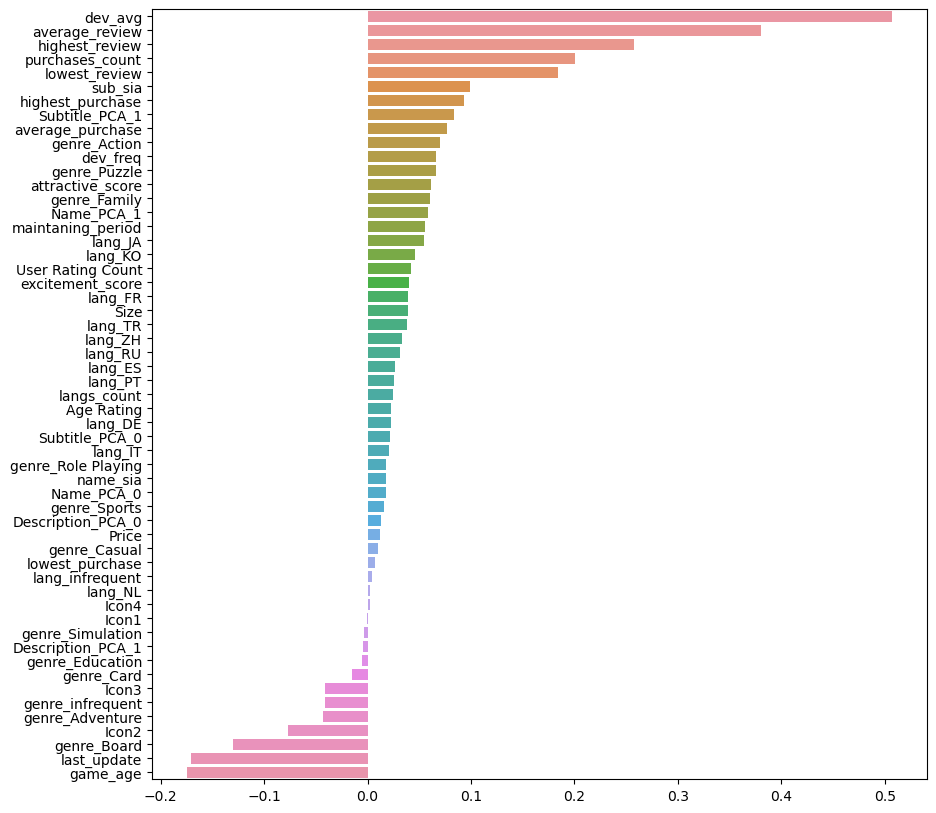

In [25]:
# plot correlation matrix between features and target
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_x.corrwith(df_y)
corr = corr.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=corr.values, y=corr.index)
# plt.show()

### Feature Selection

In [30]:
df_x = scale_data_std(df_x)

# Feature selection
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=10)
df_x_select =  selector.fit_transform(df_x, df_y)

# Save the selector
pickle.dump(selector, open('encoders/selector.pkl', 'wb'))

In [31]:
# Print the selected features
for i in range(len(selector.get_support())): 
    if selector.get_support()[i]:
        print(df_x.columns[i])

game_age
last_update
dev_avg
genre_Board
purchases_count
highest_purchase
sub_sia
lowest_review
highest_review
average_review


### Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score


In [33]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/LR_model.pkl', 'wb'))



Training MSE:  0.27267100640017905
Training R2:  0.3624502144708158


### Ridge Regression

In [34]:
# Create a ridge regression model
model = Ridge(alpha=20)

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/Ridge_model.pkl', 'wb'))


Training MSE:  0.272700254765877
Training R2:  0.36238182696778054


### Lasso Regression

In [35]:
# Create a lasso regression model
model = Lasso(alpha=0.001)

# Train the model
model.fit(df_x_select, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/Lasso_model.pkl', 'wb'))


Training MSE:  0.27270114805495826
Training R2:  0.36237973831057535


### Elastic Net Regression

In [36]:
# Create an elastic net regression model
model = ElasticNet(alpha=0.001)

# Train the model
model.fit(df_x_select, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/ElasticNet_model.pkl', 'wb'))


Training MSE:  0.2726800994461322
Training R2:  0.36242895342963


### Polynomial Regression

In [37]:
# Create a polynomial regression model
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(df_x_select)

# Save the polynomial features
pickle.dump(poly, open('encoders/poly.pkl', 'wb'))

# Train the model
model = LinearRegression()
model.fit(X_train_poly, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(X_train_poly)))
print('Training R2: ', r2_score(df_y, model.predict(X_train_poly)))

# Save the model
pickle.dump(model, open('models/Polynomial_model.pkl', 'wb'))


Training MSE:  0.2520513846317533
Training R2:  0.41066229103043084


### XGBoost

In [38]:
# Create an XGBoost model

import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(df_x_select, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/XGBoost_model.pkl', 'wb'))

Training MSE:  0.20153257300047184
Training R2:  0.5287836048654746


### Gradient Boosting

In [39]:
# Create a Gradient Boosting model

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(learning_rate=0.1)

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/GradientBoosting_model.pkl', 'wb'))

Training MSE:  0.195811821821976
Training R2:  0.5421596646639375


### Random Forest Regression

In [40]:
# Create a Random Forest Regressor model

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=5)

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/RandomForest_model.pkl', 'wb'))

Training MSE:  0.233490486187683
Training R2:  0.4540607329053944


In [41]:
# Create CatBoost Regressor model

from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=500, 
                          learning_rate=0.070767,
                          depth=5,
                          early_stopping_rounds=5,
                          verbose=200)

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/CatBoost_model.pkl', 'wb'))

0:	learn: 0.6421283	total: 157ms	remaining: 1m 18s
200:	learn: 0.4454389	total: 394ms	remaining: 586ms
400:	learn: 0.3901768	total: 656ms	remaining: 162ms
499:	learn: 0.3699809	total: 787ms	remaining: 0us
Training MSE:  0.13688588210811647
Training R2:  0.6799382305725573


In [42]:
# print catboost weights with the feature names and biases
print(model.get_feature_importance(prettified=True)) 

  Feature Id  Importances
0          2    22.473180
1          9    20.257927
2          0    17.663571
3          8    10.975795
4          1     9.087799
5          7     8.387573
6          4     4.011383
7          5     3.518831
8          3     2.393215
9          6     1.230726


In [43]:
# Create AdaBoost Regressor model

from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor(n_estimators=100, learning_rate=0.01)

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/AdaBoost_model.pkl', 'wb'))

Training MSE:  0.27734907051615215
Training R2:  0.3515121289984894


## Done